<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# Generative Adversarial Networks - DCGAN <a class="tocSkip">

In [1]:
import math
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.14.5
Pandas:0.22.0
Matplotlib:2.2.2
TensorFlow:1.11.0
Keras:2.2.4


Using TensorFlow backend.


In [2]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# Get the MNIST data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(os.path.join(datasetslib.datasets_root,'mnist'), one_hot=False)

x_train = mnist.train.images
x_test = mnist.test.images
y_train = mnist.train.labels
y_test = mnist.test.labels

pixel_size = 28

def norm(x):
    return (x-0.5)/0.5

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/ubuntu/datasets/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/ubuntu/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/ubuntu/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/ubuntu/datasets/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
n_z = 256
z_test = np.random.uniform(-1.0,1.0,size=[8,n_z])

In [5]:
# Function to display the images and labels
def display_images(images):
    for i in range(images.shape[0]):
        plt.subplot(1, 8, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# DCGAN in Keras

In [6]:
import keras
from keras.layers import Dense, Input, LeakyReLU, Activation
from keras.layers import UpSampling2D, Conv2D, Reshape, Flatten, MaxPooling2D
from keras.models import Sequential, Model

In [7]:
tf.reset_default_graph()
keras.backend.clear_session()

In [8]:
# graph hyperparameters
g_learning_rate = 0.00001
d_learning_rate = 0.01

n_x = 784  # number of pixels in the MNIST image as number of inputs

# number of hidden layers for generator and discriminator
g_n_layers = 3
d_n_layers = 1
# filters in each hidden layer
g_n_filters = [64,32,16]
d_n_filters = [64]


n_width=28
n_height=28
n_depth=1


# define generator

g_model = Sequential(name='g')
g_model.add(Dense(units=5*5*128,  
                  input_shape=(n_z,),
                  name='g_in'
                 ))
#g_model.add(BatchNormalization())
g_model.add(Activation('tanh',name='g_in_act'))

g_model.add(Reshape(target_shape=(5,5,128), 
                  input_shape=(5*5*128,),
                  name='g_in_reshape'
                 )
         )
for i in range(0,g_n_layers):
    g_model.add(UpSampling2D(size=[2,2],
                             name='g_{}_up2d'.format(i)
                            ))
    g_model.add(Conv2D(filters=g_n_filters[i],
                       kernel_size=(5,5),
                       padding='same',
                       name='g_{}_conv2d'.format(i)
                      ))
    g_model.add(Activation('tanh',name='g_{}_act'.format(i)))
    
g_model.add(Flatten(name='g_out_flatten'))

g_model.add(Dense(units=n_x, activation='tanh',name='g_out'))
print('Generator:')
g_model.summary()
g_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=g_learning_rate)
             )

# define discriminator

d_model = Sequential(name='d')
d_model.add(Reshape(target_shape=(n_width,n_height,n_depth), 
                  input_shape=(n_x,),
                  name='d_0_reshape'
                 )
         )


for i in range(0,d_n_layers):
    d_model.add(Conv2D(filters=d_n_filters[i], 
                     kernel_size=(5,5), 
                     padding='same', 
                     name='d_{}_conv2d'.format(i) 
                    ) 
             )
    d_model.add(Activation('tanh',name='d_{}_act'.format(i)))

    d_model.add(MaxPooling2D(pool_size=(2,2), 
                             strides=(2,2),
                             name='d_{}_maxpool'.format(i)
                          ) 
             )

d_model.add(Flatten(name='d_out_flatten'))
d_model.add(Dense(units=1, activation='sigmoid',name='d_out'))
print('Discriminator:')
d_model.summary()
d_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=d_learning_rate)
             )

# define GAN network
d_model.trainable=False
z_in = Input(shape=(n_z,),name='z_in')
x_in = g_model(z_in)
gan_out = d_model(x_in)

gan_model = Model(inputs=z_in,outputs=gan_out,name='gan')
print('GAN:')
gan_model.summary()
gan_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=g_learning_rate)
             )

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_in (Dense)                 (None, 3200)              822400    
_________________________________________________________________
g_in_act (Activation)        (None, 3200)              0         
_________________________________________________________________
g_in_reshape (Reshape)       (None, 5, 5, 128)         0         
_________________________________________________________________
g_0_up2d (UpSampling2D)      (None, 10, 10, 128)       0         
_________________________________________________________________
g_0_conv2d (Conv2D)          (None, 10, 10, 64)        204864    
_________________________________________________________________
g_0_act (Activation)         (None, 10, 10, 64)        0         
_________________________________________________________________
g_1_up2d (UpSampling2D)      (None, 20, 20, 64)        0         

epoch: 0000   d_loss = 0.565165  g_loss = 1.114490


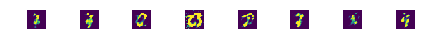

epoch: 0002   d_loss = 0.537465  g_loss = 1.112344


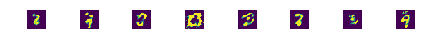

epoch: 0004   d_loss = 0.529195  g_loss = 1.171843


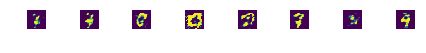

KeyboardInterrupt: 

In [13]:
# training hyperparameters

n_epochs = 400
batch_size = 10
#n_batches = int(mnist.train.num_examples / batch_size)
n_batches = 100
n_epochs_print = 2

for epoch in range(n_epochs+1):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    for batch in range(n_batches):
        x_batch, _ = mnist.train.next_batch(batch_size)
        x_batch = norm(x_batch)
        z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
        g_batch = g_model.predict(z_batch)
        
        x_in = np.concatenate([x_batch,g_batch])
        
        y_out = np.ones(batch_size*2)
        y_out[:batch_size]=0.9
        y_out[batch_size:]=0.1
        
        d_model.trainable=True
        batch_d_loss = d_model.train_on_batch(x_in,y_out)

        z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
        x_in=z_batch
        
        y_out = np.ones(batch_size)
            
        d_model.trainable=False
        batch_g_loss = gan_model.train_on_batch(x_in,y_out)
        
        epoch_d_loss += batch_d_loss 
        epoch_g_loss += batch_g_loss 
    if epoch % n_epochs_print == 0:
        average_d_loss = epoch_d_loss / n_batches
        average_g_loss = epoch_g_loss / n_batches
        print('epoch: {0:04d}   d_loss = {1:0.6f}  g_loss = {2:0.6f}'
              .format(epoch,average_d_loss,average_g_loss))
        # predict images using generator model trained            
        x_pred = g_model.predict(z_test)
        display_images(x_pred.reshape(-1,pixel_size,pixel_size))   